In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2021-03-20 14:34:25--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-03-20 14:34:25--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [     <=>            ]  33.20M  33.6MB/s    in 1.0s    

2021-03-20 14:34:26 (33.6 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

In [90]:
from torch.utils.tensorboard import SummaryWriter
from torch.autograd import Variable

import torchvision.transforms as transforms
import torchvision
import torchvision.datasets as datasets
import torchvision.utils as vutils

from torch.utils.data.dataloader import default_collate
import torch.utils.data

import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch

# import MNIST

import numpy as np

def divide_by_classes(dataset, batch_size):
    part1 = []
    part2 = []

    targets = dataset.targets
    for index, num_target in enumerate(targets):
        if num_target < 5:
            part1.append(dataset.data[index])

        else:
            part2.append(dataset.data[index])

    images_part1 = np.moveaxis(np.array(part1), -1, 1) / 255
    images_part2 = np.moveaxis(np.array(part2), -1, 1) / 255

    loader_part1 = torch.utils.data.DataLoader(torch.from_numpy(images_part1), batch_size=batch_size,
                                         shuffle=True)

    loader_part2 = torch.utils.data.DataLoader(torch.from_numpy(images_part2), batch_size=batch_size,
                                         shuffle=True) 

    return loader_part1, loader_part2


cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

transforms = transforms.Compose(
    [
     transforms.ToTensor(), 
    transforms.Normalize((0.1307,), (0.3081,))
    ]
)

batch_size = 64
lr = 0.0002
epochs = 20
latent_space = 100
lambda_gp = 10
num_of_channels = 3
image_size = 32

dataset_train = datasets.CIFAR10(root='dataset/', 
                         transform=transforms,
                         download=True,
                         train=True)

dataset_test = datasets.CIFAR10(root='dataset/', 
                         transform=transforms,
                         download=True,
                         train=False)

train_part1, train_part2 = divide_by_classes(dataset_train, batch_size)
test_part1, test_part2 = divide_by_classes(dataset_test, batch_size)


Files already downloaded and verified
Files already downloaded and verified


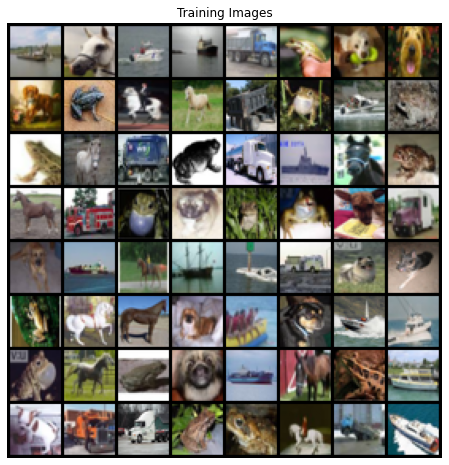

In [91]:
import matplotlib.pyplot as plt


real_batch = next(iter(train_part2))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [92]:
assert len(train_part1) == len(train_part2)
assert len(test_part1) == len(test_part2)

print('Datasets have the same shapes.')

Datasets have the same shapes.


In [93]:
class DiscriminatorConvNet(nn.Module):

    def __init__(self, image_size, num_of_channels, ngpu=1):
        super(DiscriminatorConvNet, self).__init__()
        self.ngpu = ngpu
        self.image_size = image_size
        self.num_of_channels = num_of_channels
        self.main = self.layers()

    def layers(self):
        n_hidden_layers = np.int(np.log2(self.image_size) - 3)

        modules = []
        modules += [
              nn.Conv2d(self.num_of_channels, self.image_size, 4, 2, 1, bias=False),
              nn.LeakyReLU(0.2, inplace=True)
        ]

        for num in range(n_hidden_layers):
            n_input_channels = 2 ** num
            n_output_channels = 2 ** (num + 1)

            modules += [
                  nn.Conv2d(self.image_size * n_input_channels, self.image_size * n_output_channels, 4, 2, 1, bias=False),
                  nn.BatchNorm2d(self.image_size * n_output_channels),
                  nn.LeakyReLU(0.2, inplace=True)
            ]

        modules += [
              nn.Conv2d(self.image_size * n_output_channels, 1, 4, 1, 0, bias=False),
              # nn.Sigmoid()
        ]

        return nn.Sequential(*modules)

    def forward(self, input):
        return self.main(input)

class DiscriminatorMLP(nn.Module):
    
    def __init__(self, image_size):
        super(DiscriminatorMLP, self).__init__()

        self.image_size = image_size
        self.model = nn.Sequential(
            nn.Linear(num_of_channels * self.image_size ** 2, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 1),
        )

    def forward(self, x):

        x = x.view(x.shape[0], -1)
        return self.model(x)

In [94]:
class GPLoss(nn.Module):
    def __init__(self):
        super(GPLoss, self).__init__()

    def forward(self, real_samples, fake_samples, D):
        
        # Random weight term for interpolation between real and fake samples
        alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))

        # Get random interpolation between real and fake samples
        interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)

        d_interpolates = D(interpolates)
        fake = Variable(Tensor(real_samples.shape[0], 1, 1, 1).fill_(1.0), requires_grad=False)

        # Get gradient w.r.t. interpolates
        gradients = autograd.grad(
            outputs=d_interpolates,
            inputs=interpolates,
            grad_outputs=fake,
            create_graph=True,
            retain_graph=True,
            only_inputs=True,
        )[0]

        gradients = gradients.view(gradients.size(0), -1)
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        
        return gradient_penalty

class CEpsilonLoss(nn.Module):
    def __init__(self, epsilon=0.1):
        super(CEpsilonLoss, self).__init__()
        self.epsilon = epsilon
    
    def forward(self, real_objects, fake_objects, fake_validity):

        real = real_objects.view(real_objects.size(0), -1)
        fake = fake_objects.view(fake_objects.size(0), -1)

        c_matrix = torch.cdist(real, fake)
        fake_term = torch.mean(fake_validity)

        term2 = -(fake_validity - c_matrix) / self.epsilon
        term2 = torch.exp(term2).mean(1)
        term2 = torch.log(term2)

        return fake_term - self.epsilon * term2.mean()

class WCLoss(nn.Module):

    def __init__(self):
        super(WCLoss, self).__init__()

    def forward(self, real, fake):
        return torch.mean(real) - torch.mean(fake)

class WeightClipper(object):

    def __init__(self, epsilon):
        self.epsilon = epsilon

    def __call__(self, module):
        if hasattr(module, 'weight'):
            w = module.weight.data
            w = w.clamp(-epsilon, epsilon)
            module.weight.data = w

In [95]:
!pip install pot

In [96]:
import ot
from sklearn.metrics import pairwise_distances

def get_gt_wass(fake_objects, real_objects):
    fake_hist = torch.ones(fake_objects.shape[0]) / fake_objects.shape[0]
    real_hist = torch.ones(fake_objects.shape[0]) / fake_objects.shape[0]

    fake_norms = torch.Tensor([torch.norm(tensor) for tensor in fake_objects])
    real_norms = torch.Tensor([torch.norm(tensor) for tensor in real_objects])

    M = pairwise_distances(real_norms.reshape(-1, 1), fake_norms.reshape(-1, 1))

    wass = (ot.emd(fake_hist, real_hist, M) * M).sum()
    
    return wass

In [ ]:
from tqdm.notebook import tqdm

discriminator = DiscriminatorMLP(image_size=image_size)

if cuda:
    discriminator.cuda()

optimizer = torch.optim.RMSprop(discriminator.parameters(), lr=5e-5)
# optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
img_list = []
real_label = 1
verbose = True
freq = max(epochs//10,1)
epsilon = 0.01

# criterion = WCLoss()
clipper = WeightClipper(epsilon)
criterion = WCLoss()

for epoch in range(epochs):
    discriminator.train()

    for i, (imgs1, imgs2) in tqdm(enumerate(zip(train_part1, train_part2))):

        imgs_m = Variable(imgs1.type(Tensor)) # tensor batch_size, num_of_channels, img_size, img_size
        imgs_v = Variable(imgs2.type(Tensor)) # tensor batch_size, num_of_channels, img_size, img_size
      
        optimizer.zero_grad() 

        phi = discriminator(imgs_m).view(-1) # vector == batch_size
        psi = discriminator(imgs_v).view(-1) # vector == batch_size

        loss = -criterion(phi, psi)
        # loss = criterion(imgs_m, imgs_v, phi)
        # gradient_penalty = criterion(imgs_m, imgs_v, discriminator)
        # loss = -torch.mean(phi) + torch.mean(psi) + lambda_gp * gradient_penalty
        loss.backward()

        optimizer.step()
        discriminator.apply(clipper)

    discriminator.eval() 
    if verbose and epoch%freq==0:

        losses_val = []
        val_errors = []
        val_dest = []
        val_ground = []

        for i, (imgs1, imgs2) in enumerate(zip(test_part1, test_part2)):

            imgs_m = Variable(imgs1.type(Tensor))
            imgs_v = Variable(imgs2.type(Tensor))

            phi = discriminator(imgs_m).view(-1)
            psi = discriminator(imgs_v).view(-1)

            d_est = -criterion(phi, psi)
            # d_est = criterion(imgs_m, imgs_v, phi)
            # gradient_penalty = criterion(imgs_m, imgs_v, discriminator)
            # d_est = -torch.mean(phi) + torch.mean(psi) + lambda_gp * gradient_penalty
            val_dest.append(d_est)

            d_ground = get_gt_wass(imgs_m, imgs_v)
            val_ground.append(d_ground)

            error = (d_est - d_ground) / d_ground
            losses_val.append(error)

        mean_val = sum(losses_val)/len(losses_val)

        print('Val epoch {}'.format(epoch), \
          ', Loss : {:.8}'.format(mean_val))




Val epoch 0 , Loss : -1.0844169



Val epoch 2 , Loss : -1.1718314



Val epoch 4 , Loss : -1.2015228



Val epoch 6 , Loss : -1.2267281



Val epoch 8 , Loss : -1.2388783



Val epoch 10 , Loss : -1.244058



Val epoch 12 , Loss : -1.2503701



Val epoch 14 , Loss : -1.2531309



Val epoch 16 , Loss : -1.2549603



Val epoch 18 , Loss : -1.2564442


In [97]:
np.mean([x.item() for x in losses_val]), np.std([x.item() for x in losses_val])

(-1.2564440105534807, 0.17076508869815185)